<a href="https://colab.research.google.com/github/Samy-OUABID/IAE-METZ-Samy-Yassin/blob/main/Examen_mod%C3%A9lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install statsmodels arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from arch import arch_model


In [4]:
#définition des fonds Small Caps

funds_Small_FRA = ["0P0000L1MW.F"]  # Fonds Small caps français
funds_Small_LUX = ["0P0001D3JX.F"]  # Fonds Small caps Luxembourgeois
benchmark = "DJSC.L"  # Benchmark Small Caps Europe

#liste complète des fonds à récupérer
all_funds = funds_Small_FRA + funds_Small_LUX + [benchmark]

fund_names = {
    "0P0000L1MW.F": "Fonds Small Caps France",
    "0P0001D3JX.F": "Fonds Small Caps Luxembourg",
    "DJSC.L": "Benchmark Small Caps Europe"
}

In [5]:
#téléchargement des données sur 2 ans
fund_data = yf.download(all_funds, start="2023-01-01", end="2025-01-01")['Close']
fund_data_clean = fund_data.dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [6]:
#calcul des rendements quotidiens
fund_returns = fund_data_clean.pct_change().dropna()
print(fund_returns)

Ticker      0P0000L1MW.F  0P0001D3JX.F    DJSC.L
Date                                            
2023-01-04      0.002624      0.010272  0.014248
2023-01-05      0.007552      0.011816  0.004429
2023-01-06     -0.004749     -0.000815  0.005512
2023-01-09      0.020430      0.016581  0.016308
2023-01-10      0.002009      0.001069 -0.007686
...                  ...           ...       ...
2024-12-19     -0.012145     -0.012460 -0.014003
2024-12-20     -0.013979      0.013535  0.003017
2024-12-23      0.008106     -0.002716  0.004035
2024-12-27      0.008654      0.004993  0.003361
2024-12-30     -0.001931     -0.002484 -0.003059

[471 rows x 3 columns]


In [7]:
#calcul des rendements cumulés
cumulative_returns = (1 + fund_returns).cumprod() - 1
print(cumulative_returns)

Ticker      0P0000L1MW.F  0P0001D3JX.F    DJSC.L
Date                                            
2023-01-04      0.002624      0.010272  0.014248
2023-01-05      0.010195      0.022210  0.018741
2023-01-06      0.005398      0.021377  0.024356
2023-01-09      0.025938      0.038312  0.041061
2023-01-10      0.028000      0.039422  0.033060
...                  ...           ...       ...
2024-12-19      0.045729      0.210161 -0.044944
2024-12-20      0.031111      0.226541 -0.042062
2024-12-23      0.039469      0.223209 -0.038197
2024-12-27      0.048465      0.229317 -0.034964
2024-12-30      0.046441      0.226263 -0.037916

[471 rows x 3 columns]


In [26]:
#calcul des indicateurs de rentabilité
annual_returns = fund_returns.mean() * 252
annual_volatility = fund_returns.std() * np.sqrt(252)
free_rate = 0.02
sharpe_ratio = (annual_returns - free_rate) / annual_volatility

In [22]:
print(annual_returns)

Ticker
0P0000L1MW.F    0.034972
0P0001D3JX.F    0.120103
DJSC.L         -0.008930
dtype: float64


In [23]:
print(annual_volatility)


Ticker
0P0000L1MW.F    0.146266
0P0001D3JX.F    0.147943
DJSC.L          0.153317
dtype: float64


In [25]:
print(sharpe_ratio)

Ticker
0P0000L1MW.F    0.102363
0P0001D3JX.F    0.676627
DJSC.L         -0.188696
dtype: float64


In [ ]:
#calcul de la covariance et du beta
cov_matrix = fund_returns.cov()
cov_with_benchmark = cov_matrix[benchmark]
var_benchmark = fund_returns[benchmark].var()
betas = cov_with_benchmark / var_benchmark


In [ ]:
print(betas)

Ticker
0P0000L1MW.F    0.522882
0P0001D3JX.F    0.181161
DJSC.L          1.000000
Name: DJSC.L, dtype: float64


In [ ]:
#calcul du ratio de Sortino
def sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252)
    expected_return = returns.mean() * 252
    return (expected_return - risk_free_rate) / downside_deviation

sortino_ratios = fund_returns.apply(sortino_ratio)

In [ ]:
print(sortino_ratios)

Ticker
0P0000L1MW.F    0.353509
0P0001D3JX.F    1.173521
DJSC.L         -0.086945
dtype: float64


In [ ]:
#calcul de l'alpha de jensen
def alpha_jensen(fund_returns, benchmark_returns, risk_free_rate=0.0):
    common_dates = fund_returns.dropna().index.intersection(benchmark_returns.dropna().index)
    X = sm.add_constant(benchmark_returns.loc[common_dates])
    y = fund_returns.loc[common_dates]
    model = sm.OLS(y, X).fit()
    return model.params['const']

alpha_values = {fund: alpha_jensen(fund_returns[fund], fund_returns[benchmark]) for fund in funds_Small_FRA + funds_Small_LUX}


In [ ]:
print(alpha_values)

{'0P0000L1MW.F': 0.00015814289639788415, '0P0001D3JX.F': 0.0004833061870932539}


In [ ]:
#calcul du maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

max_drawdowns = {fund: calculate_max_drawdown(cumulative_returns[fund]) for fund in cumulative_returns.columns}


In [ ]:
print(max_drawdowns)

{'0P0000L1MW.F': -1.4666263645384034, '0P0001D3JX.F': -1.0483192486005393, 'DJSC.L': -1.687771873872229}


In [ ]:
garch_results = {}
for fund in funds_Small_FRA + funds_Small_LUX:
    model = arch_model(fund_returns[fund].dropna(), vol='Garch', p=1, q=1)
    garch_results[fund] = model.fit(disp='off')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.472e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.667e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:

final_indicators = pd.DataFrame({
    'Rendement Annuel': annual_returns,
    'Volatilité Annuelle': annual_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Alpha de Jensen': pd.Series(alpha_values),
    'Bêta': betas,
    'Ratio de Sortino': sortino_ratios,
    'Maximum Drawdown': pd.Series(max_drawdowns)
})

print("\nTableau récapitulatif des indicateurs :")
print(final_indicators)



Tableau récapitulatif des indicateurs :
              Rendement Annuel  Volatilité Annuelle  Sharpe Ratio  \
0P0000L1MW.F          0.034972             0.146266      0.239101   
0P0001D3JX.F          0.120103             0.147943      0.811814   
DJSC.L               -0.009332             0.153309     -0.060873   

              Alpha de Jensen      Bêta  Ratio de Sortino  Maximum Drawdown  
0P0000L1MW.F         0.000158  0.522882          0.353509         -1.466626  
0P0001D3JX.F         0.000483  0.181161          1.173521         -1.048319  
DJSC.L                    NaN  1.000000         -0.086945         -1.687772  


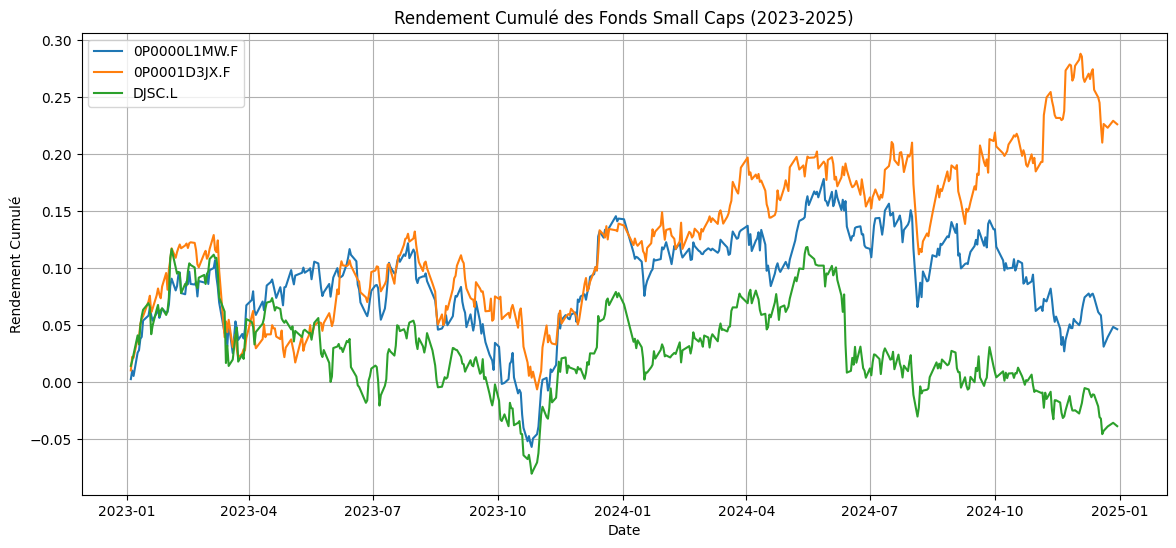

In [ ]:
#courbe des rendements cumulés
plt.figure(figsize=(14, 6))
for fund in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[fund], label=fund)
plt.title("Rendement Cumulé des Fonds Small Caps (2023-2025)")
plt.xlabel("Date")
plt.ylabel("Rendement Cumulé")
plt.legend()
plt.grid(True)
plt.show()

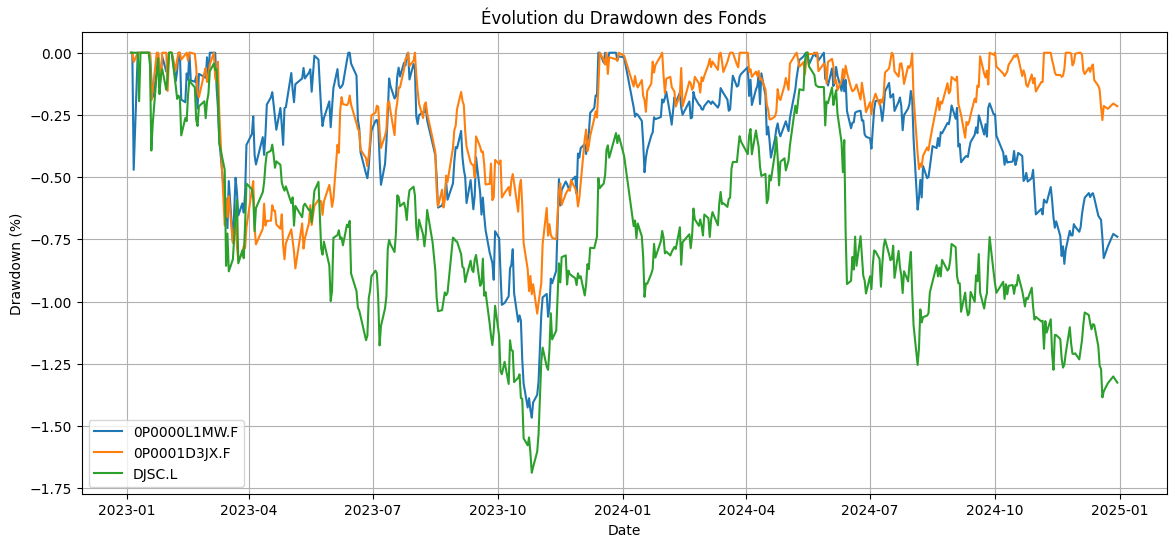

In [ ]:
#visualisation du drawdown
plt.figure(figsize=(14, 6))
for fund in cumulative_returns.columns:
    peak = cumulative_returns[fund].cummax()
    drawdown = (cumulative_returns[fund] - peak) / peak
    plt.plot(drawdown, label=f"{fund}")
plt.title("Évolution du Drawdown des Fonds")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()


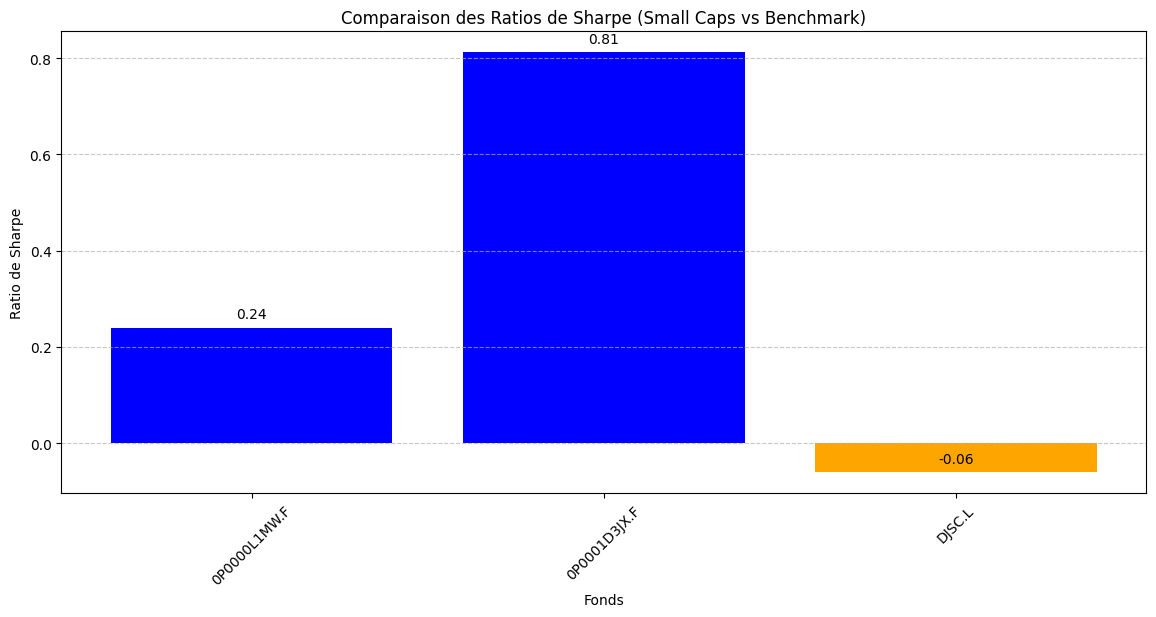

In [ ]:
#visualisation des ratios de sharpe
plt.figure(figsize=(14, 6))
sharpe_df = pd.DataFrame({
    'Fonds': funds_Small_FRA + funds_Small_LUX + [benchmark],
    'Sharpe Ratio': [sharpe_ratio[fund] for fund in funds_Small_FRA + funds_Small_LUX + [benchmark]]
})
plt.bar(sharpe_df['Fonds'], sharpe_df['Sharpe Ratio'], color=['blue'] * len(funds_Small_FRA + funds_Small_LUX) + ['orange'])
plt.title("Comparaison des Ratios de Sharpe (Small Caps vs Benchmark)")
plt.ylabel("Ratio de Sharpe")
plt.xlabel("Fonds")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(sharpe_df['Sharpe Ratio']):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)
plt.show()


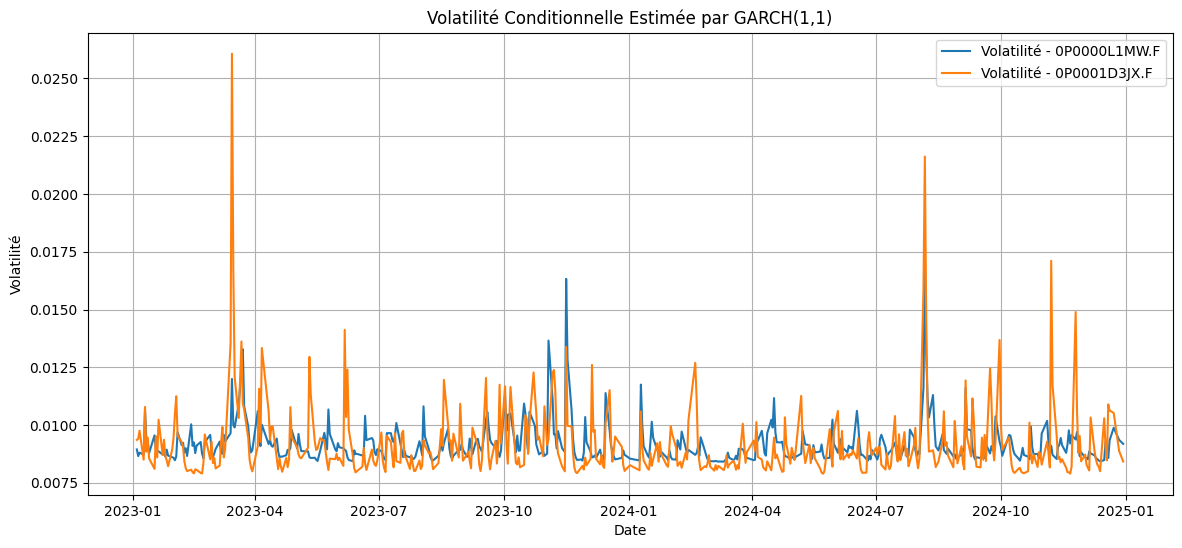

In [ ]:
#visualisation de la volatilité conditionnelle
plt.figure(figsize=(14, 6))
for fund in funds_Small_FRA + funds_Small_LUX:
    plt.plot(garch_results[fund].conditional_volatility, label=f"Volatilité - {fund}")
plt.title("Volatilité Conditionnelle Estimée par GARCH(1,1)")
plt.xlabel("Date")
plt.ylabel("Volatilité")
plt.legend()
plt.grid(True)
plt.show()